In [1]:
import os
import json
import pandas as pd
from utils import load_test_case, load_all_conf
import matplotlib.pyplot as plt

# Load Data

In [2]:
TEST_SUITE = "1677152050268280982"
TEST_CASE = "test_1"

conf, svea2_df, svea5_df = load_test_case(TEST_SUITE, TEST_CASE)
conf_df = load_all_conf(TEST_SUITE)

# Unique Values of Test Cases

In [3]:
"TARGE_VEL", conf_df["TARG_VEL"].unique(), "TIME_STEP",conf_df["TIME_STEP"].unique(), "DATA_SIZE", conf_df["DATA_SIZE"].unique(), "DATA_FREQ", conf_df["DATA_FREQ"].unique(),"COMP_TIME", conf_df["COMP_TIME"].unique(), "COMP_ORDR", conf_df["COMP_ORDR"].unique(),"THROUGHPUT", conf_df["THROUGHPUT"].unique()

('TARGE_VEL',
 array([ 5, 10, 20]),
 'TIME_STEP',
 array([0.1]),
 'DATA_SIZE',
 array([ 1, 10]),
 'DATA_FREQ',
 array([10, 30, 50]),
 'COMP_TIME',
 array([0.1, 0.2, 0.4, 0.8, 1.2]),
 'COMP_ORDR',
 array([0, 1, 2]),
 'THROUGHPUT',
 array([ 10,  30,  50, 100, 300, 500]))

ERROR in: 136


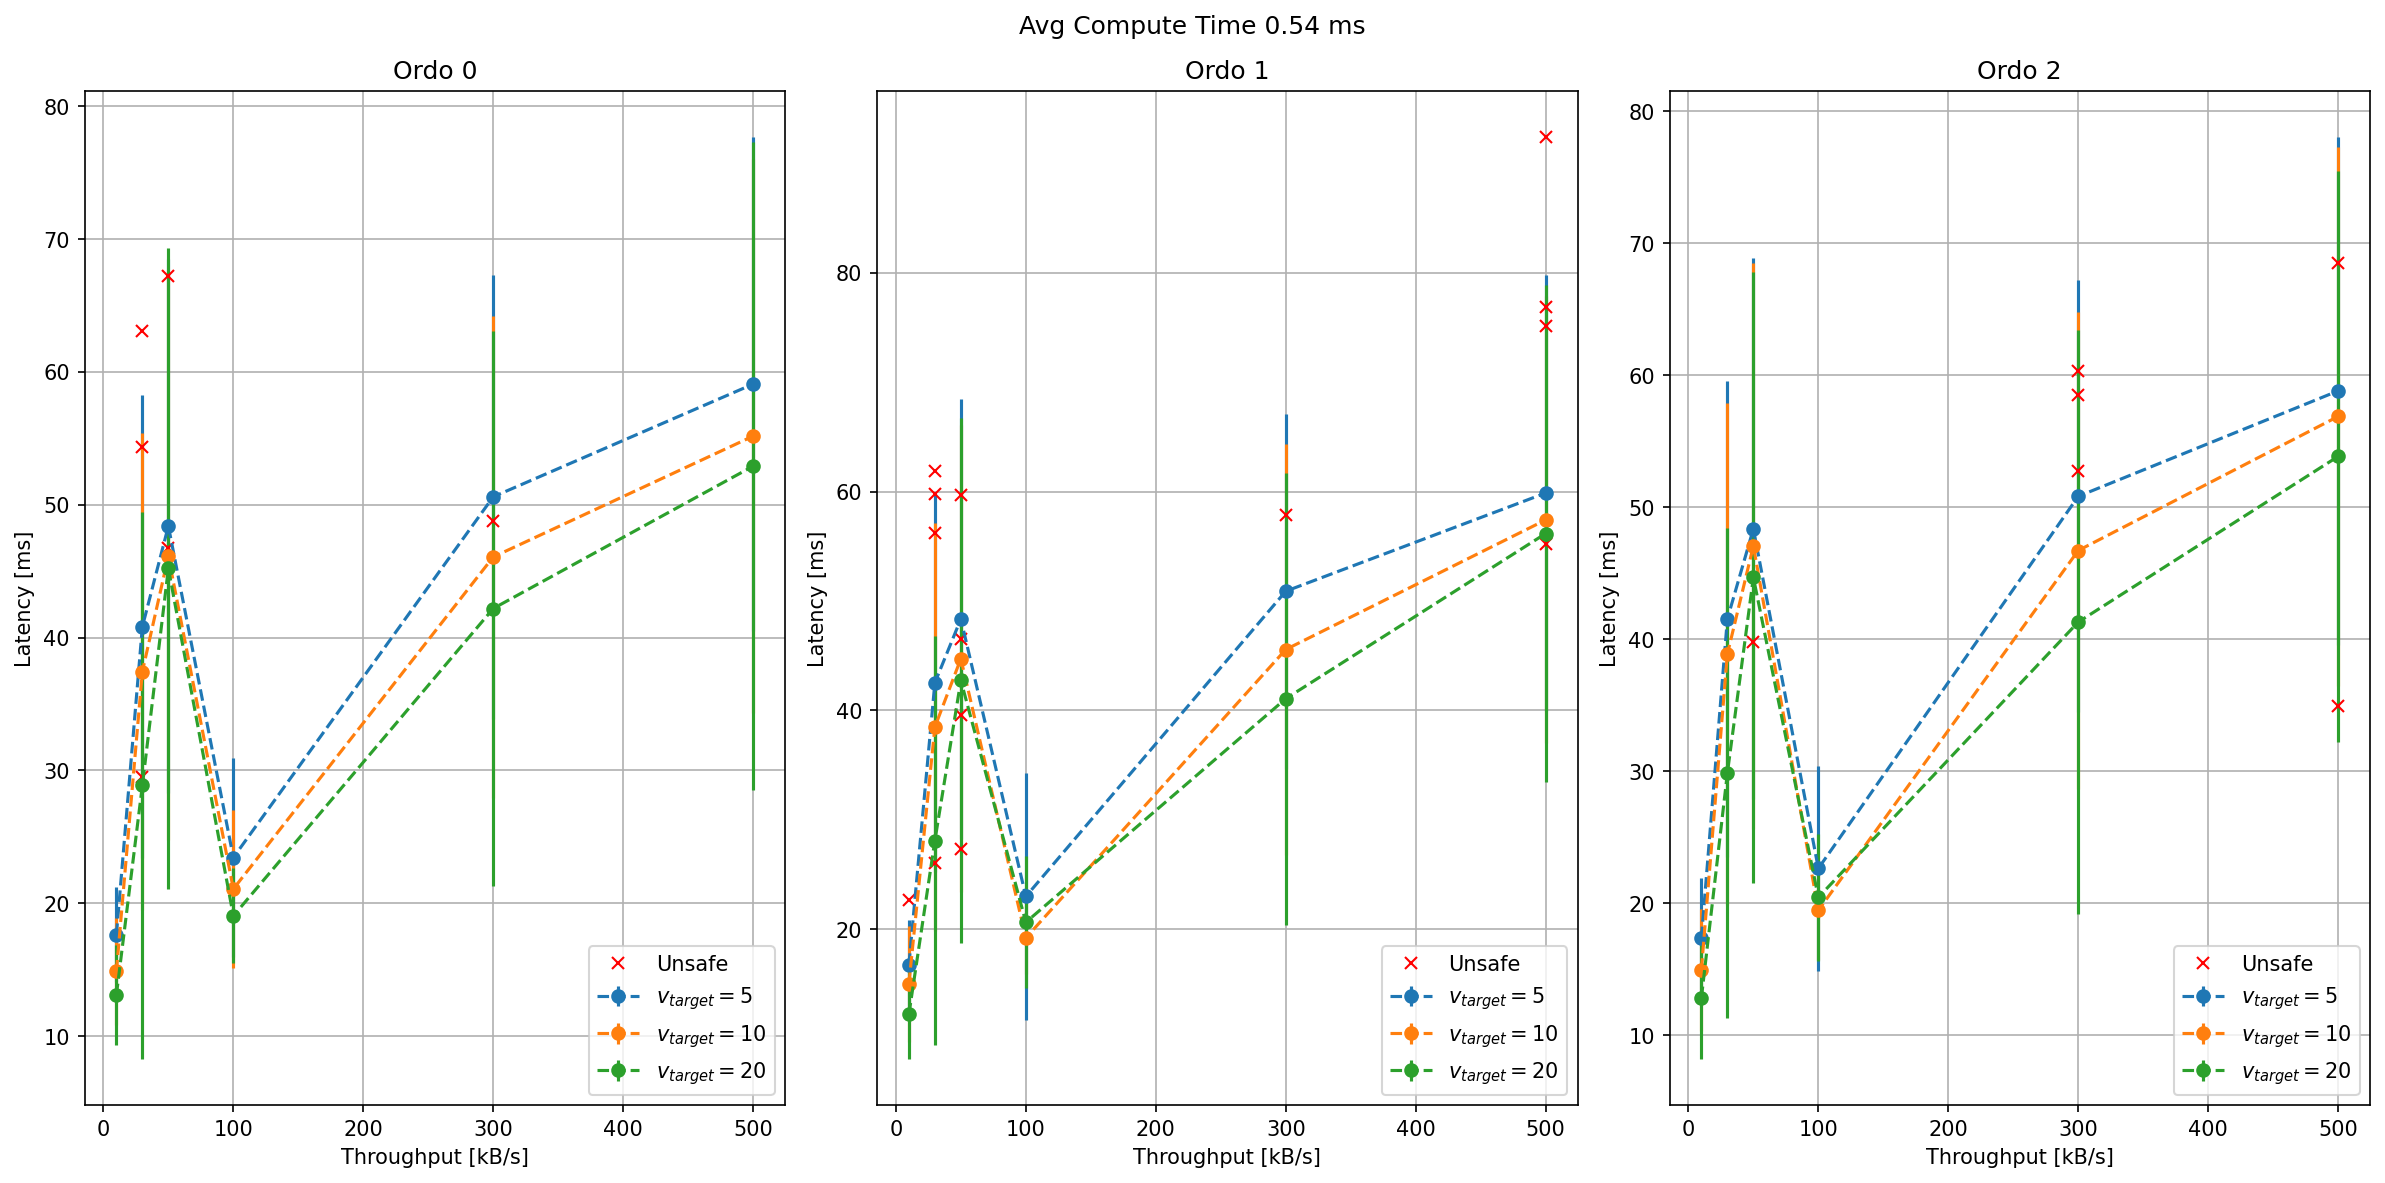

In [40]:
unique_throughputs = conf_df["THROUGHPUT"].unique().tolist() # use as x-axis
target_vel = conf_df["TARG_VEL"].unique().tolist() # use as legend
comp_time_mean = conf_df["COMP_TIME"].mean()
ordos = conf_df["COMP_ORDR"].unique().tolist()

fig = plt.figure(figsize=(16,8),dpi=150)
fig.set_tight_layout(True)
for k, ordo in enumerate(ordos):
    ax = fig.add_subplot(1, len(ordos), k+1)
    unsafe = pd.DataFrame()
    for vel in target_vel:
    # for vel in reversed(target_vel):
        x_tp = []
        y_lat = []
        y_std = []
        for i, throughput in enumerate(unique_throughputs):
            test_cases = conf_df.loc[(conf_df["THROUGHPUT"] == throughput) & (conf_df["TARG_VEL"] == vel) & (conf_df["COMP_ORDR"] == ordo)].index.tolist()
            # Load all the test cases with the particular throughput and target_velocity
            svea2_df, svea5_df = pd.DataFrame(), pd.DataFrame()
            for test_case in test_cases:
                try:
                    _, svea2_loc_df, svea5_loc_df = load_test_case(TEST_SUITE,f"test_{test_case}")
                    svea2_df = pd.concat([svea2_df,svea2_loc_df])
                    svea5_df = pd.concat([svea5_df,svea5_loc_df])
                except Exception as e:
                    print("ERROR in:", test_case)

            x_tp.append(throughput)
            y_lat.append(svea2_df["LATENCY"].loc[svea2_df["IS_SAFE"]==True].mean())
            y_std.append(svea2_df["LATENCY"].loc[svea2_df["IS_SAFE"]==True].std())

            unsafe = pd.concat([unsafe, svea2_df.loc[svea2_df["IS_SAFE"]==False][["THROUGHPUT", "IS_SAFE", "LATENCY"]]])
            # unsafe = pd.concat([unsafe, svea2_df.loc[svea2_df["IS_SAFE"]==False]])
            
            # ax =fig.add_subplot(1,len(unique_throughputs),i+1)
            # print(throughput,vel, svea2_df.shape)
            # ax.plot(svea2_df["THROUGHPUT"],svea2_df["LATENCY"], "-o",label=r"$v_{target}=$"+str(vel))
        ax.errorbar(x_tp,y_lat, yerr=y_std, fmt="--o", label=r"$v_{target}=$"+str(vel))
    ax.plot(unsafe["THROUGHPUT"], unsafe["LATENCY"], "rx", label="Unsafe")
    
    ax.set_xlabel("Throughput [kB/s]")
    ax.set_ylabel("Latency [ms]")
    ax.set_title(f"Ordo {ordo}")
    ax.grid()
    ax.legend(loc="lower right")
plt.suptitle(f"Avg Compute Time {comp_time_mean:.2f} ms")
plt.savefig(TEST_SUITE+".png")